In [2]:
# LSTM with Kospi data (250309)

from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
import FinanceDataReader as fdr

In [3]:
# 금융지주사 데이터를 이용하여 다음 날짜의 종목 지수를 예상하는 코드(안)

object = ['KS11', '105560', '316140', '086790', '024110']    # 금융지주사 KRX 코드
df_krx = fdr.StockListing('KRX')
print(len(df_krx))


2874


In [4]:
# plot legend에 한글 문자열 전달 시 발생하는 기호 제거

for i in range(len(object)):
    print(str(df_krx[df_krx['Code'] == object[i]]['Name'].values).replace('\'', ''))

result = []

for i in range(len(object)):
    result.append(str(df_krx[df_krx['Code'] == object[i]]['Name'].values).replace('\'', '').replace('[', '').replace(']', ''))

result

[]
[KB금융]
[우리금융지주]
[하나금융지주]
[기업은행]


['', 'KB금융', '우리금융지주', '하나금융지주', '기업은행']

In [5]:
# pyplot에서 한글 폰트 깨짐 문제

import platform
import matplotlib.pyplot as plt

os = platform.system()

# Win
if os == 'Windows':
    plt.rc('font', family = 'Malgun Gothic')

# Mac
elif os == 'Darwin':
    plt.rc('font', family = 'AppleGothic')

# pyplot에서 마이너스 기호 깨지 문제

plt.rcParams['axes.unicode_minus'] = False

In [6]:
# ARIMA 함수 형태로 정의 - 반복 사용

def cal_residuals(code):
    df = fdr.DataReader(code, '2024')
    series_df = df['Change'].values
    model = ARIMA(series_df, order = (5, 1, 0))
    model_fit = model.fit()
    residuals = DataFrame(model_fit.resid)

    return residuals

In [7]:
df_ = fdr.DataReader(object[0], '2024')

1 001 2024-01-01 00:00:00 2025-12-31 00:00:00


1 001 2024-01-01 00:00:00 2025-12-31 00:00:00


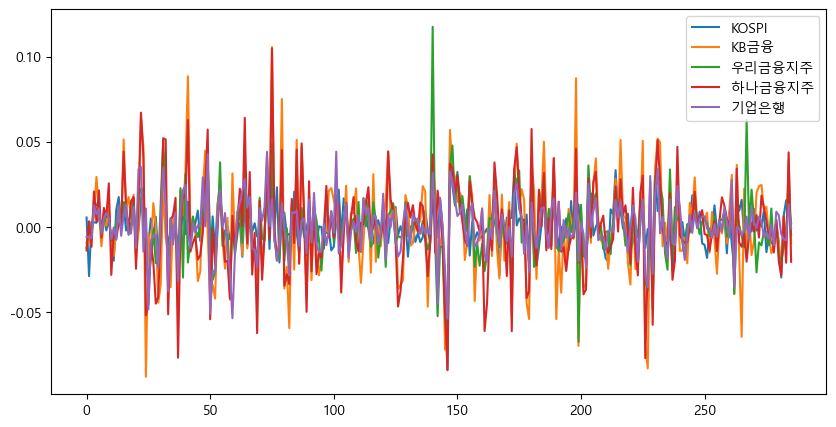

In [8]:
plt.figure(figsize=(10, 5))
ax = plt.gca()

for i in range(len(object)):
    cal_residuals(object[i]).plot(label=object[i], ax=ax)  # 여러 개 중첩

[result[i] for i in range(len(result))]   # legend 리스트 만들기
result[0] = 'KOSPI'    # 공란 처리된 첫번째 칸에 KOSPI 텍스트 입력
plt.legend(result)

plt.show()


In [9]:
import pandas as pd
import numpy as np

df_bind = pd.DataFrame()

for i in range(len(object)):
    df_bind = pd.concat([df_bind, cal_residuals(object[i])], axis=1)

df_bind = df_bind.set_index(df_.index)

# 반복문으로 리스트 만들기 : 칼럼명 변경
df_bind.columns = [result[i] for i in range(len(result))]

# Time Series에서 Time index를 제거
timeseries = np.array(df_bind)
timesteps = timeseries.shape[0]
n_features = timeseries.shape[1]

timeseries

print(timesteps)  # 전체 데이터 갯수
print(n_features) # 5개 (금융지주사 + KOSPI 지수) 항목을 입력으로 사용  

1 001 2024-01-01 00:00:00 2025-12-31 00:00:00
286
5


In [ ]:
# 입/출력 데이터의 정의

def temporalize(X, y, lookback):   # lookback의 정의
    output_X = []
    output_y = []

    for i in range(len(X) - lookback - 1):
        t = []
        for j in range(1, lookback + 1):
            t.append(X[[i+j+1], :])
        output_X.append(t)
        output_y.append(y[i+lookback])      # 참고할 과거 기간 15일을 더한 다음 값값
    return output_X, output_y         

In [33]:
timesteps = 15   # 지난 15일 간의 데이터를 관찰하고 다음날을 예측

# Lagging 현상 방지를 위하여 KOSPI 데이터를 제외 (250309) => [:, 1:]
X, y = temporalize(X = timeseries[:, 1:], y = timeseries[:, 0], lookback = timesteps)   

X

[[array([[-0.00190047, -0.00536009, -0.01168309, -0.00649818]]),
  array([[0.00632921, 0.01551445, 0.02079797, 0.01251737]]),
  array([[0.0293672 , 0.01277565, 0.00301598, 0.00740872]]),
  array([[0.00901655, 0.01259607, 0.02139977, 0.01100169]]),
  array([[-0.01140978, -0.00432437, -0.00629378, -0.00398081]]),
  array([[0.00328153, 0.00260392, 0.01117232, 0.0051039 ]]),
  array([[0.00068111, 0.00697856, 0.00592879, 0.00813364]]),
  array([[0.01228799, 0.00583875, 0.02558503, 0.00523844]]),
  array([[-0.01026233, -0.00819363, -0.0281723 , -0.00713341]]),
  array([[-0.01705638, -0.00644133, -0.00259801, -0.00027667]]),
  array([[-0.00052757,  0.00237006, -0.00701783, -0.00756262]]),
  array([[0.00430179, 0.01237305, 0.0022336 , 0.01267086]]),
  array([[ 1.41995367e-05, -1.95475879e-03,  2.30342056e-04,
          -5.23880361e-03]]),
  array([[0.05133234, 0.01461064, 0.04418552, 0.006883  ]]),
  array([[0.01046055, 0.0110992 , 0.01127641, 0.01317566]])],
 [array([[0.00632921, 0.01551445, 

In [ ]:
n_features = 4     # 5에서 수정 - KOSPI 값을 추정하기위해 금융지주사 4개 데이터만 사용
X = np.array(X)
X = X.reshape(X.shape[0], timesteps, n_features)

In [35]:
X[0]

array([[-1.90046738e-03, -5.36009002e-03, -1.16830941e-02,
        -6.49818215e-03],
       [ 6.32921375e-03,  1.55144530e-02,  2.07979736e-02,
         1.25173662e-02],
       [ 2.93671983e-02,  1.27756505e-02,  3.01598481e-03,
         7.40872047e-03],
       [ 9.01654526e-03,  1.25960723e-02,  2.13997666e-02,
         1.10016921e-02],
       [-1.14097785e-02, -4.32437411e-03, -6.29377524e-03,
        -3.98080831e-03],
       [ 3.28153410e-03,  2.60392126e-03,  1.11723206e-02,
         5.10389816e-03],
       [ 6.81112182e-04,  6.97856411e-03,  5.92879054e-03,
         8.13363575e-03],
       [ 1.22879881e-02,  5.83875200e-03,  2.55850293e-02,
         5.23844464e-03],
       [-1.02623337e-02, -8.19362648e-03, -2.81722969e-02,
        -7.13340818e-03],
       [-1.70563777e-02, -6.44132934e-03, -2.59801212e-03,
        -2.76667510e-04],
       [-5.27569958e-04,  2.37005526e-03, -7.01783025e-03,
        -7.56261631e-03],
       [ 4.30178628e-03,  1.23730511e-02,  2.23359922e-03,
      

In [36]:
y[0]

0.012902475713445513

In [46]:
# LSTM 모델의 정의

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

model = Sequential()
model.add(LSTM(15, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
# model.add(LSTM(30, activation='relu', return_sequences=True))
model.add(LSTM(15, activation='relu', return_sequences=False))
model.add(Dense(8))   # y값 1개 출력
model.add(Dense(1))   # y값 1개 출력

model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 15, 15)         │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 15)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,197 (12.49 KB)

 Trainable params: 3,197 (12.49 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
len(X)

270

In [ ]:
x_train = X[0:250]
y_train = y[0:250]

x_test = X[250:]
y_test = y[250:]

In [80]:
len(X[0:250])

250

In [86]:
len(X[250:])

20

In [72]:
# 아래와 같이 numpy array로 변환해야 fit model 진행 가능
X_train_arr = np.array(x_train)
Y_train_arr = np.array(y_train)

X_test_arr = np.array(x_test)
Y_test_arr = np.array(y_test)


In [73]:
# fir model

model.fit(X_train_arr, Y_train_arr, epochs=300, batch_size=5, verbose=0)

In [74]:
Yhat = model.predict(X_test_arr, verbose=0)

In [75]:
Yhat

array([[-0.00425928],
       [ 0.00908989],
       [ 0.00456088],
       [ 0.00801325],
       [ 0.00419435],
       [ 0.00691054],
       [ 0.00095344],
       [ 0.00281912],
       [ 0.00234139],
       [ 0.00350532],
       [-0.00788955],
       [ 0.01448837],
       [ 0.00105416],
       [ 0.01408369],
       [-0.02725243],
       [-0.00143067],
       [-0.00489148],
       [ 0.01179002],
       [ 0.00298932]], dtype=float32)

In [83]:
len(Yhat)

19

In [96]:
df_bind.index[250+17:]

DatetimeIndex(['2025-02-10', '2025-02-11', '2025-02-12', '2025-02-13',
               '2025-02-14', '2025-02-17', '2025-02-18', '2025-02-19',
               '2025-02-20', '2025-02-21', '2025-02-24', '2025-02-25',
               '2025-02-26', '2025-02-27', '2025-02-28', '2025-03-04',
               '2025-03-05', '2025-03-06', '2025-03-07'],
              dtype='datetime64[ns]', name='Date', freq=None)

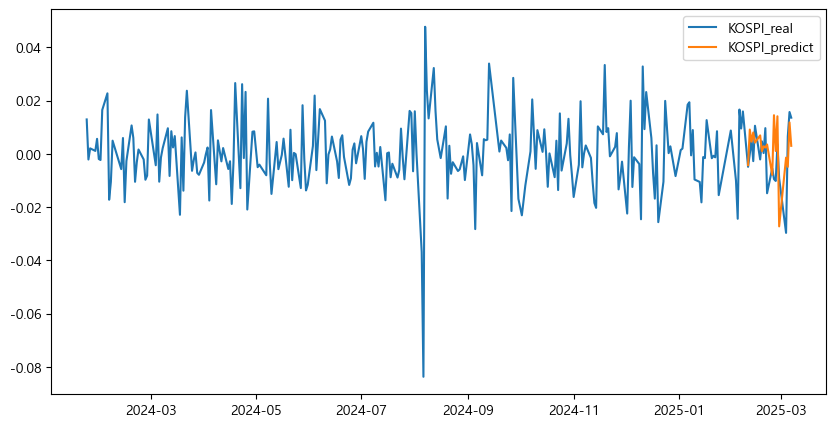

In [104]:
pyplot.figure(figsize=(10, 5))
ax = pyplot.gca()

ax.plot(df_bind.index[timesteps+1:], y)
ax.plot(df_bind.index[250+17:], Yhat)     # 시간 인덱스를 맞추기

result[0] = 'KOSPI_real'
result[1] = 'KOSPI_predict'

pyplot.legend(result)

plt.show()

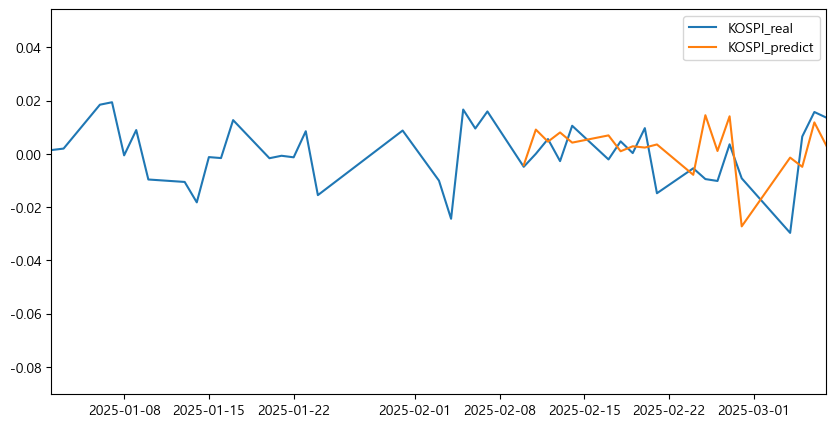

In [ ]:
# 예측 부분 시간영역 확대 (250309)

import datetime

pyplot.figure(figsize=(10, 5))
ax = pyplot.gca()

ax.plot(df_bind.index[timesteps+1:], y)
ax.plot(df_bind.index[250+17:], Yhat)   

result[0] = 'KOSPI_real'
result[1] = 'KOSPI_predict'

pyplot.legend(result)
ax.set_xlim([datetime.date(2025, 1, 2), datetime.date(2025, 3, 7)])
plt.show()